In [20]:
import numpy as np
import sympy as sy
from copy import copy
from tqdm import tqdm
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
class DynamicSystemConverter():
    def __init__(self, A, B, C):
        self.A = sy.Matrix(A)
        self.B = sy.Matrix(B)
        self.C = sy.Matrix(C)
        # assume D = np.zeros_like(B)

    def getTF(self):
        ''' computes the transfer function for sympy matrices A, B, and C'''

        sI_Ainv = self._getSI_Minv(A)
        G = self.C * sI_Ainv * self.B # + D (if D were non-zero -- also, this is not the same D as used in the DSF functions!)
        return G

    def getDSF(self):
        ''' 
            Assumes the state (the 'x' in \dot{x} = Ax + Bu) is of the 
            form such that if there are n visible states and m hidden states,
                x[:n] comprises the visible states, while
                x[n:m] = x[n:] comprises the hidden states
            This also implies that C is of the form [I, 0].
            In addition, we assume D = 0 ('D' as in y = Cx + Du)

            Calculate P and Q in 4 steps:
                1. partition A and B
                2. calculate W and V
                3. calculate D (a different D from the 'D' in y = Cx + Du)
                4. use W, D, and V to calculate P and Q
        '''
    
        A11, A12, A21, A22, B1, B2 = self._partitionAB(self.A, self.B, self.C)
    
        sI_A22inv = self._getSI_Minv(A22) # only calculate this inverse once (for speed)
        W = self._getW(A11, A12, A21, sI_A22inv)
        V = self._getV(A12, sI_A22inv, B1, B2)
        
        D = self._getD(W)
        sI_Dinv = self._getSI_Minv(D) # as above, pre-calculate this so we only take the inverse once
    
        Q = self._getQ(sI_Dinv, W, D)
        P = self._getP(sI_Dinv, V)
    
        return Q, P
    
    def convertDSFtoTF(self, Q, P):
        ''' convert a dynamic structure function to a transfer function '''
        I_Q = sy.eye(Q.shape[0]) - Q
        I_Qinv = I_Q ** -1
        G = I_Qinv * P
        G = G.applyfunc(sy.simplify) # simplify the fractions in each index
        return G

    def _getSI_Minv(self, matrix):
        ''' computes (sI - M)^{-1} '''

        eye = sy.eye(matrix.shape[0])
        s = sy.symbols("s")
        sI_M = (s * eye) - matrix
        sI_Minv = sI_M**-1
        return sI_Minv

    def _partitionAB(self, A, B, C):
        ''' Assume C is of the form [I, 0] '''
    
        numVisibleStates = C.shape[0]
    
        A11 = A[:numVisibleStates,:numVisibleStates]
        A12 = A[:numVisibleStates,numVisibleStates:]
        A21 = A[numVisibleStates:,:numVisibleStates]
        A22 = A[numVisibleStates:,numVisibleStates:]
    
        B1 = B[:numVisibleStates,:numVisibleStates]
        B2 = B[numVisibleStates:,:]
    
        return A11, A12, A21, A22, B1, B2

    def _getW(self, A11, A12, A21, sI_A22inv):
        W = A11 + (A12 * sI_A22inv * A21)
        return W
    
    def _getV(self, A12, sI_A22inv, B1, B2):
        V = (A12 * sI_A22inv * B2) + B1
        return V
    
    def _getD(self, W):
        ''' 
            so this code is a little funny because
            np.diag() on a matrix extracts the diagonals,
            but np.diag() on a vector convets it to a diagonal matrix
        '''
        D = sy.Matrix(np.diag(np.diag(np.array(W.tolist()))))
        return D
    
    def _getQ(self, sI_Dinv, W, D):
        return sI_Dinv * (W - D)
    
    def _getP(self, sI_Dinv, V):
        return sI_Dinv * V

In [6]:
A = np.array([[-1, 0, 0, 1, 0, 0],
               [ 0,-2, 0, 0, 1, 0],
               [ 0, 0,-3, 0, 0, 1],
               [ 0, 0, 1,-4, 0, 0],
               [ 1, 0, 0, 0,-5, 0],
               [ 0, 1, 0, 0, 0,-6]])

B = np.array([[0,0,0],
               [0,0,0],
               [0,0,0],
               [1,0,0],
               [0,1,0],
               [0,0,1]])

C = np.array([[1,0,0,0,0,0],
               [0,1,0,0,0,0],
               [0,0,1,0,0,0]])

In [12]:
converter = DynamicSystemConverter(A, B, C)
G1 = converter.getTF() # get the transfer function
Q, P = converter.getDSF() # get the dynamical structure function
G2 = converter.convertDSFtoTF(Q, P) 

In [19]:
print('Transfer function:')
sy.pprint(G1)

Transfer function:
⎡            4       3       2                                                
⎢           s  + 16⋅s  + 91⋅s  + 216⋅s + 180                                  
⎢─────────────────────────────────────────────────────  ──────────────────────
⎢ 6       5        4        3         2                  6       5        4   
⎢s  + 21⋅s  + 175⋅s  + 735⋅s  + 1624⋅s  + 1764⋅s + 719  s  + 21⋅s  + 175⋅s  + 
⎢                                                                             
⎢                     2                                             4       3 
⎢                    s  + 9⋅s + 18                                 s  + 14⋅s  
⎢─────────────────────────────────────────────────────  ──────────────────────
⎢ 6       5        4        3         2                  6       5        4   
⎢s  + 21⋅s  + 175⋅s  + 735⋅s  + 1624⋅s  + 1764⋅s + 719  s  + 21⋅s  + 175⋅s  + 
⎢                                                                             
⎢                                

Check if $G(s) = (I −Q(s))^{−1} P (s)$:

In [18]:
print(f'Equality achieved: {G1.equals(G2)}')

Equality achieved: True


## Problem 3

In [23]:
runsDf = pd.read_csv("runs.csv")
payoffs = runsDf[runsDf.columns[1:]].to_numpy() # [1:] gets rid of the index column that is erroneously read in

mlbAvgDf = pd.read_csv("MLBAVG.csv")
mlbAvg = mlbAvgDf[mlbAvgDf.columns[1:]].to_numpy()

gordGamDf = pd.read_csv("GordonGamel.csv")
gordGamDf = gordGamDf[gordGamDf.columns[1:]]

# read in the other players
otherPlayers = ["dspan","jsegura","kseager","mhaniger","mzunino","ncruz","rcano","rhealy"]
transitions = []
for player in otherPlayers:
    df = pd.read_csv(player + ".csv")
    transitionMatrix = df[df.columns[1:]].to_numpy()
    transitions.append(transitionMatrix)

playersToRuns = dict(zip(otherPlayers, transitions)) # we don't actually use this, but it seems right to have around

In [25]:
indices = np.arange(0, len(runsDf.columns) - 1)
encodingToIndex = dict(zip(runsDf.columns[1:-1], indices))
encodingToIndex["3"] = 24
print(encodingToIndex)

{'000 0': 0, '000 1': 1, '000 2': 2, '001 0': 3, '001 1': 4, '001 2': 5, '010 0': 6, '010 1': 7, '010 2': 8, '011 0': 9, '011 1': 10, '011 2': 11, '100 0': 12, '100 1': 13, '100 2': 14, '101 0': 15, '101 1': 16, '101 2': 17, '110 0': 18, '110 1': 19, '110 2': 20, '111 0': 21, '111 1': 22, '111 2': 23, '3': 24}


## Part 1

/Users/jakecallahan/opt/anaconda3/envs/580/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app


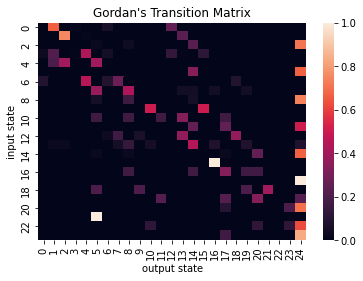

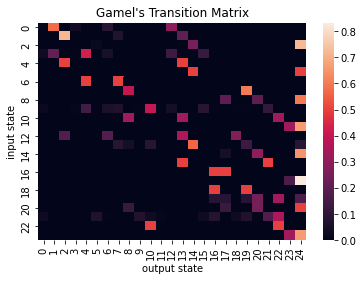

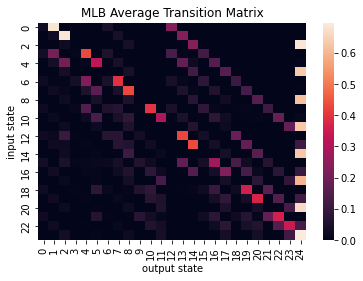

In [26]:
numStartStates = mlbAvg.shape[0]
numEndStates = mlbAvg.shape[1]

def getTransitionMatrix(df, numStartStates=numStartStates, numEndStates=numEndStates):
    
    # store historic state transitions
    tMatrix = np.zeros((numStartStates, numEndStates))
    for index, row in df.iterrows():
        i1 = encodingToIndex[row["STATE"]]
        i2 = encodingToIndex[row["NEW.STATE"]]
        tMatrix[i1, i2] += 1

    # normalize to probabilities
    sums = np.sum(tMatrix, axis=1)
    tMatrix = (tMatrix.T / np.sum(tMatrix, axis=1)).T

    # replace the missing components
    mask = sums == 0
    tMatrix[mask] = mlbAvg[mask]

    return tMatrix

# keep only the rows associated with each player
gordDf = gordGamDf[gordGamDf["batter"] == "Gordon"]
gamDf = gordGamDf[gordGamDf["batter"] == "Gamel"]

# convert to transition matrices
gordonTransition = getTransitionMatrix(gordDf)
gamelTransition = getTransitionMatrix(gamDf)

# visualize *************************

sns.heatmap(gordonTransition)
plt.title("Gordan's Transition Matrix")
plt.ylabel("input state")
plt.xlabel("output state")
plt.show()

sns.heatmap(gamelTransition)
plt.title("Gamel's Transition Matrix")
plt.ylabel("input state")
plt.xlabel("output state")
plt.show()

sns.heatmap(mlbAvg)
plt.title("MLB Average Transition Matrix")
plt.ylabel("input state")
plt.xlabel("output state")
plt.show()

## Part 3
Using an average is reasonable, since it is in a sense just using the mean of the distribution you assume the players to be distributed on. However, unless the players are extremely average (which we don't believe to be the case) then we know that the mean isn't a correct value for these specific players. If you wanted to get more specific, you might look at the MLB average for the states that we do have player data for and then examing how far away from that average the player's data is, and then use that to infer where the player's data would be for the states we don't have info for.

## Part 4

In [27]:
class SeasonModel():
    def __init__(self, lineup):
        ''' lineup is a list of transition matrices '''
        self.lineup = lineup
        assert len(self.lineup) == 9
        self.gamePoints = []

    def getPoints(self, startIndex, endIndex):
        ''' return the points earned by a given transition '''
        return payoffs[startIndex, endIndex]

    def transitionState(self, transitionMatrix, inputState):
        ''' move the markov model to the next timestep '''
        probabilities = transitionMatrix[inputState,:]
        indices = np.arange(probabilities.shape[0])
        outputState = np.random.choice(indices, p=probabilities) 
        return outputState

    def inningSim(self, currentBatter):
        ''' simulate 1 inning '''

        currentState = 0
        pointsEarned = 0
        while currentState != 24:
            # get the transition matrix for the current batter
            currentTransitionMatrix = self.lineup[currentBatter]

            # transition to the next state
            nextState = self.transitionState(currentTransitionMatrix, currentState)
            pointsEarned += self.getPoints(currentState, nextState)
            currentState = nextState

            # transition to the next batter 
            currentBatter += 1
            currentBatter = currentBatter % len(self.lineup)

        return currentBatter, pointsEarned

    def gameSim(self,):
        ''' simulate 9 innings using the given lineup '''

        currentBatter = 0
        gamePointsEarned = 0
        for i in range(9):
            currentBatter, inningPoints = self.inningSim(currentBatter)
            gamePointsEarned += inningPoints
        self.gamePoints.append(gamePointsEarned) 
    
    def battingSim(self,totalGames=162):
        ''' simulate a season's worth of games and record the points ''' 
        for i in range(totalGames):
            self.gameSim()
            self.shuffleLineup()
        return np.mean(self.gamePoints)

    def shuffleLineup(self):
        ''' shuffle the lineup to make a season more realistic '''
        random.shuffle(self.lineup)


## Part 5

In [28]:
def compareLineups(lineup1, lineup2, numIterations):
    ''' given two lineups (lists of transition matrices),
    return the simulated scores across 'numIterations' simulations '''
    model1 = SeasonModel(lineup1)
    model2 = SeasonModel(lineup2)

    model1Scores = []
    model2Scores = []
    for i in tqdm(range(numIterations)):
        meanModel1SeasonScore = model1.battingSim()
        meanModel2SeasonScore = model2.battingSim()

        model1Scores.append(meanModel1SeasonScore)
        model2Scores.append(meanModel2SeasonScore)

    return model1Scores, model2Scores

def visualizeLineups(scores1, scores2, name1, name2):
    ''' utility function for visualizing the difference between two lineups '''
    
    print()
    print("mean score for ", name1, np.mean(scores1))
    print("mean score for ", name2, np.mean(scores2))

    if np.mean(scores1) > np.mean(scores2):
        print("the team would be better off with", name1)
    elif np.mean(scores1) < np.mean(scores2):
        print("the team would be better off with", name2)
    else:
        print("both players are equally good")   
    plt.hist(scores1, label=name1, alpha=0.5)
    plt.hist(scores2, label=name2, alpha=0.5)
    plt.legend()
    plt.title("Mean Season/Game Scores")
    plt.show()

## Part 6

100%|██████████| 100/100 [00:37<00:00,  2.68it/s]


mean score for  gordon 5.544224723190939
mean score for  gamel 5.827305455734874
the team would be better off with gamel


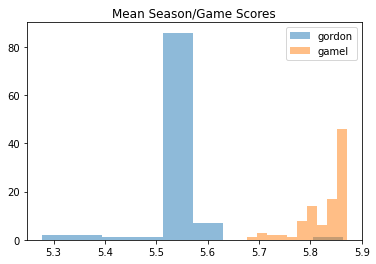

In [29]:
gordonLineup = copy(transitions)
gordonLineup.append(gordonTransition)

gamelLineup = copy(transitions)
gamelLineup.append(gamelTransition)

gordonScores, gamelScores = compareLineups(gordonLineup, gamelLineup, 100)

visualizeLineups(gordonScores, gamelScores, "gordon", "gamel")